# DSC180A Causal Discovery of Remote Work and Mental Health
group members: Evelyn, Vivan, Jason, Yishan

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("data.csv")
data = data.drop(columns = ["Physical_Activity","Employee_ID","Mental_Health_Condition"])
data.head()

,Age,Gender,Job_Role,Industry,Years_of_Experience,Work_Location,Hours_Worked_Per_Week,Number_of_Virtual_Meetings,Work_Life_Balance_Rating,Stress_Level,Access_to_Mental_Health_Resources,Productivity_Change,Social_Isolation_Rating,Satisfaction_with_Remote_Work,Company_Support_for_Remote_Work,Sleep_Quality,Region
0,32,Non-binary,HR,Healthcare,13,Hybrid,47,7,2,Medium,No,Decrease,1,Unsatisfied,1,Good,Europe
1,40,Female,Data Scientist,IT,3,Remote,52,4,1,Medium,No,Increase,3,Satisfied,2,Good,Asia
2,59,Non-binary,Software Engineer,Education,22,Hybrid,46,11,5,Medium,No,No Change,4,Unsatisfied,5,Poor,North America
3,27,Male,Software Engineer,Finance,20,Onsite,32,8,4,High,Yes,Increase,3,Unsatisfied,3,Poor,Europe
4,49,Male,Sales,Consulting,32,Onsite,35,12,2,High,Yes,Decrease,3,Unsatisfied,3,Average,North America


## EDA

In [3]:
data.columns

Index(['Age', 'Gender', 'Job_Role', 'Industry', 'Years_of_Experience',
       'Work_Location', 'Hours_Worked_Per_Week', 'Number_of_Virtual_Meetings',
       'Work_Life_Balance_Rating', 'Stress_Level',
       'Access_to_Mental_Health_Resources', 'Productivity_Change',
       'Social_Isolation_Rating', 'Satisfaction_with_Remote_Work',
       'Company_Support_for_Remote_Work', 'Sleep_Quality', 'Region'],
      dtype='object')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Age                                5000 non-null   int64 
 1   Gender                             5000 non-null   object
 2   Job_Role                           5000 non-null   object
 3   Industry                           5000 non-null   object
 4   Years_of_Experience                5000 non-null   int64 
 5   Work_Location                      5000 non-null   object
 6   Hours_Worked_Per_Week              5000 non-null   int64 
 7   Number_of_Virtual_Meetings         5000 non-null   int64 
 8   Work_Life_Balance_Rating           5000 non-null   int64 
 9   Stress_Level                       5000 non-null   object
 10  Access_to_Mental_Health_Resources  5000 non-null   object
 11  Productivity_Change                5000 non-null   object
 12  Social

### Numerical Variables

In [5]:
data.describe()

,Age,Years_of_Experience,Hours_Worked_Per_Week,Number_of_Virtual_Meetings,Work_Life_Balance_Rating,Social_Isolation_Rating,Company_Support_for_Remote_Work
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,40.995000,17.810200,39.614600,7.559000,2.984200,2.993800,3.007800
std,11.296021,10.020412,11.860194,4.636121,1.410513,1.394615,1.399046
min,22.000000,1.000000,20.000000,0.000000,1.000000,1.000000,1.000000
25%,31.000000,9.000000,29.000000,4.000000,2.000000,2.000000,2.000000
50%,41.000000,18.000000,40.000000,8.000000,3.000000,3.000000,3.000000
75%,51.000000,26.000000,50.000000,12.000000,4.000000,4.000000,4.000000
max,60.000000,35.000000,60.000000,15.000000,5.000000,5.000000,5.000000


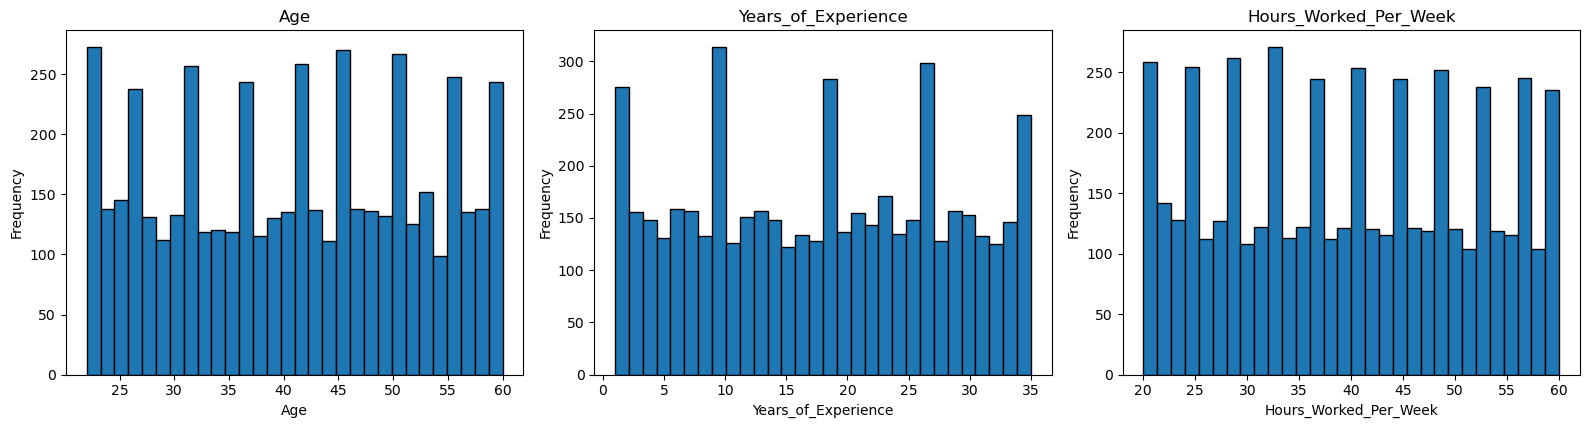

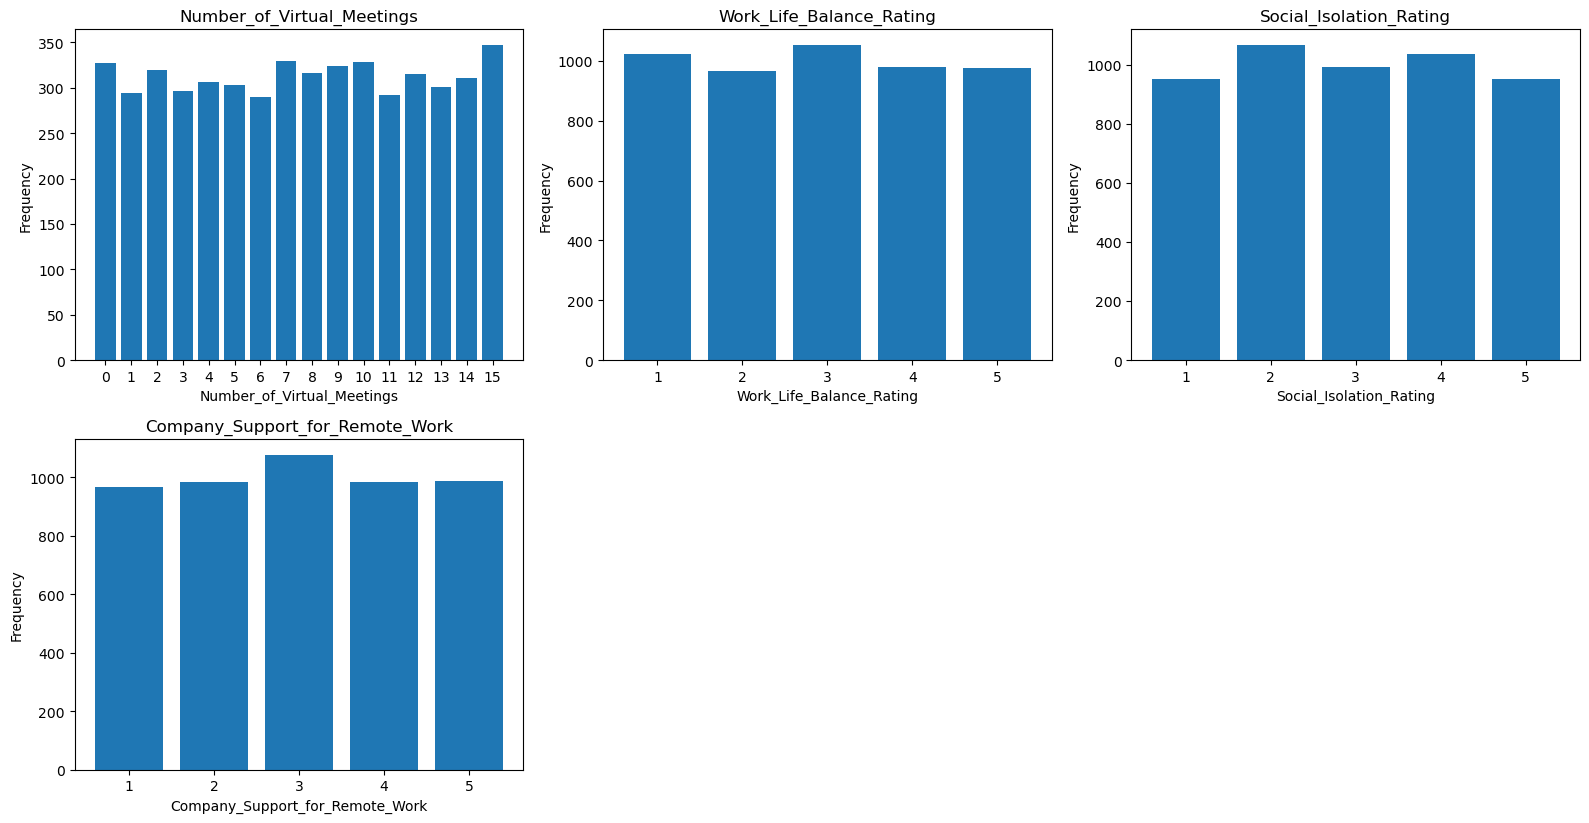

In [6]:
#eda for numerical
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()

plt.figure(figsize=(16, 12))

for i, column in enumerate(numerical_columns[:3]):
    plt.subplot(3, 3, i + 1) 
    plt.hist(data[column], bins=30, edgecolor='black')  # Create histogram
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout() 
plt.show()
plt.figure(figsize=(16, 12))
for i, column in enumerate(numerical_columns[3:]):  # Change the slice as needed
    plt.subplot(3, 3, i + 1)
    
    counts = data[column].value_counts().sort_index()
    
    plt.bar(counts.index, counts.values)
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.xticks(ticks=counts.index)

plt.tight_layout() 
plt.show()

<Axes: >

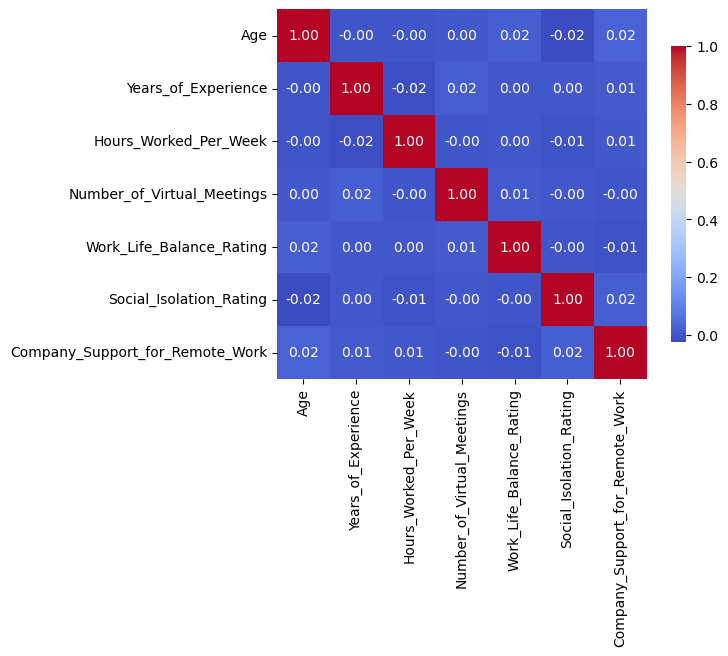

In [7]:
correlation_matrix = data[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

### Categorical Variables

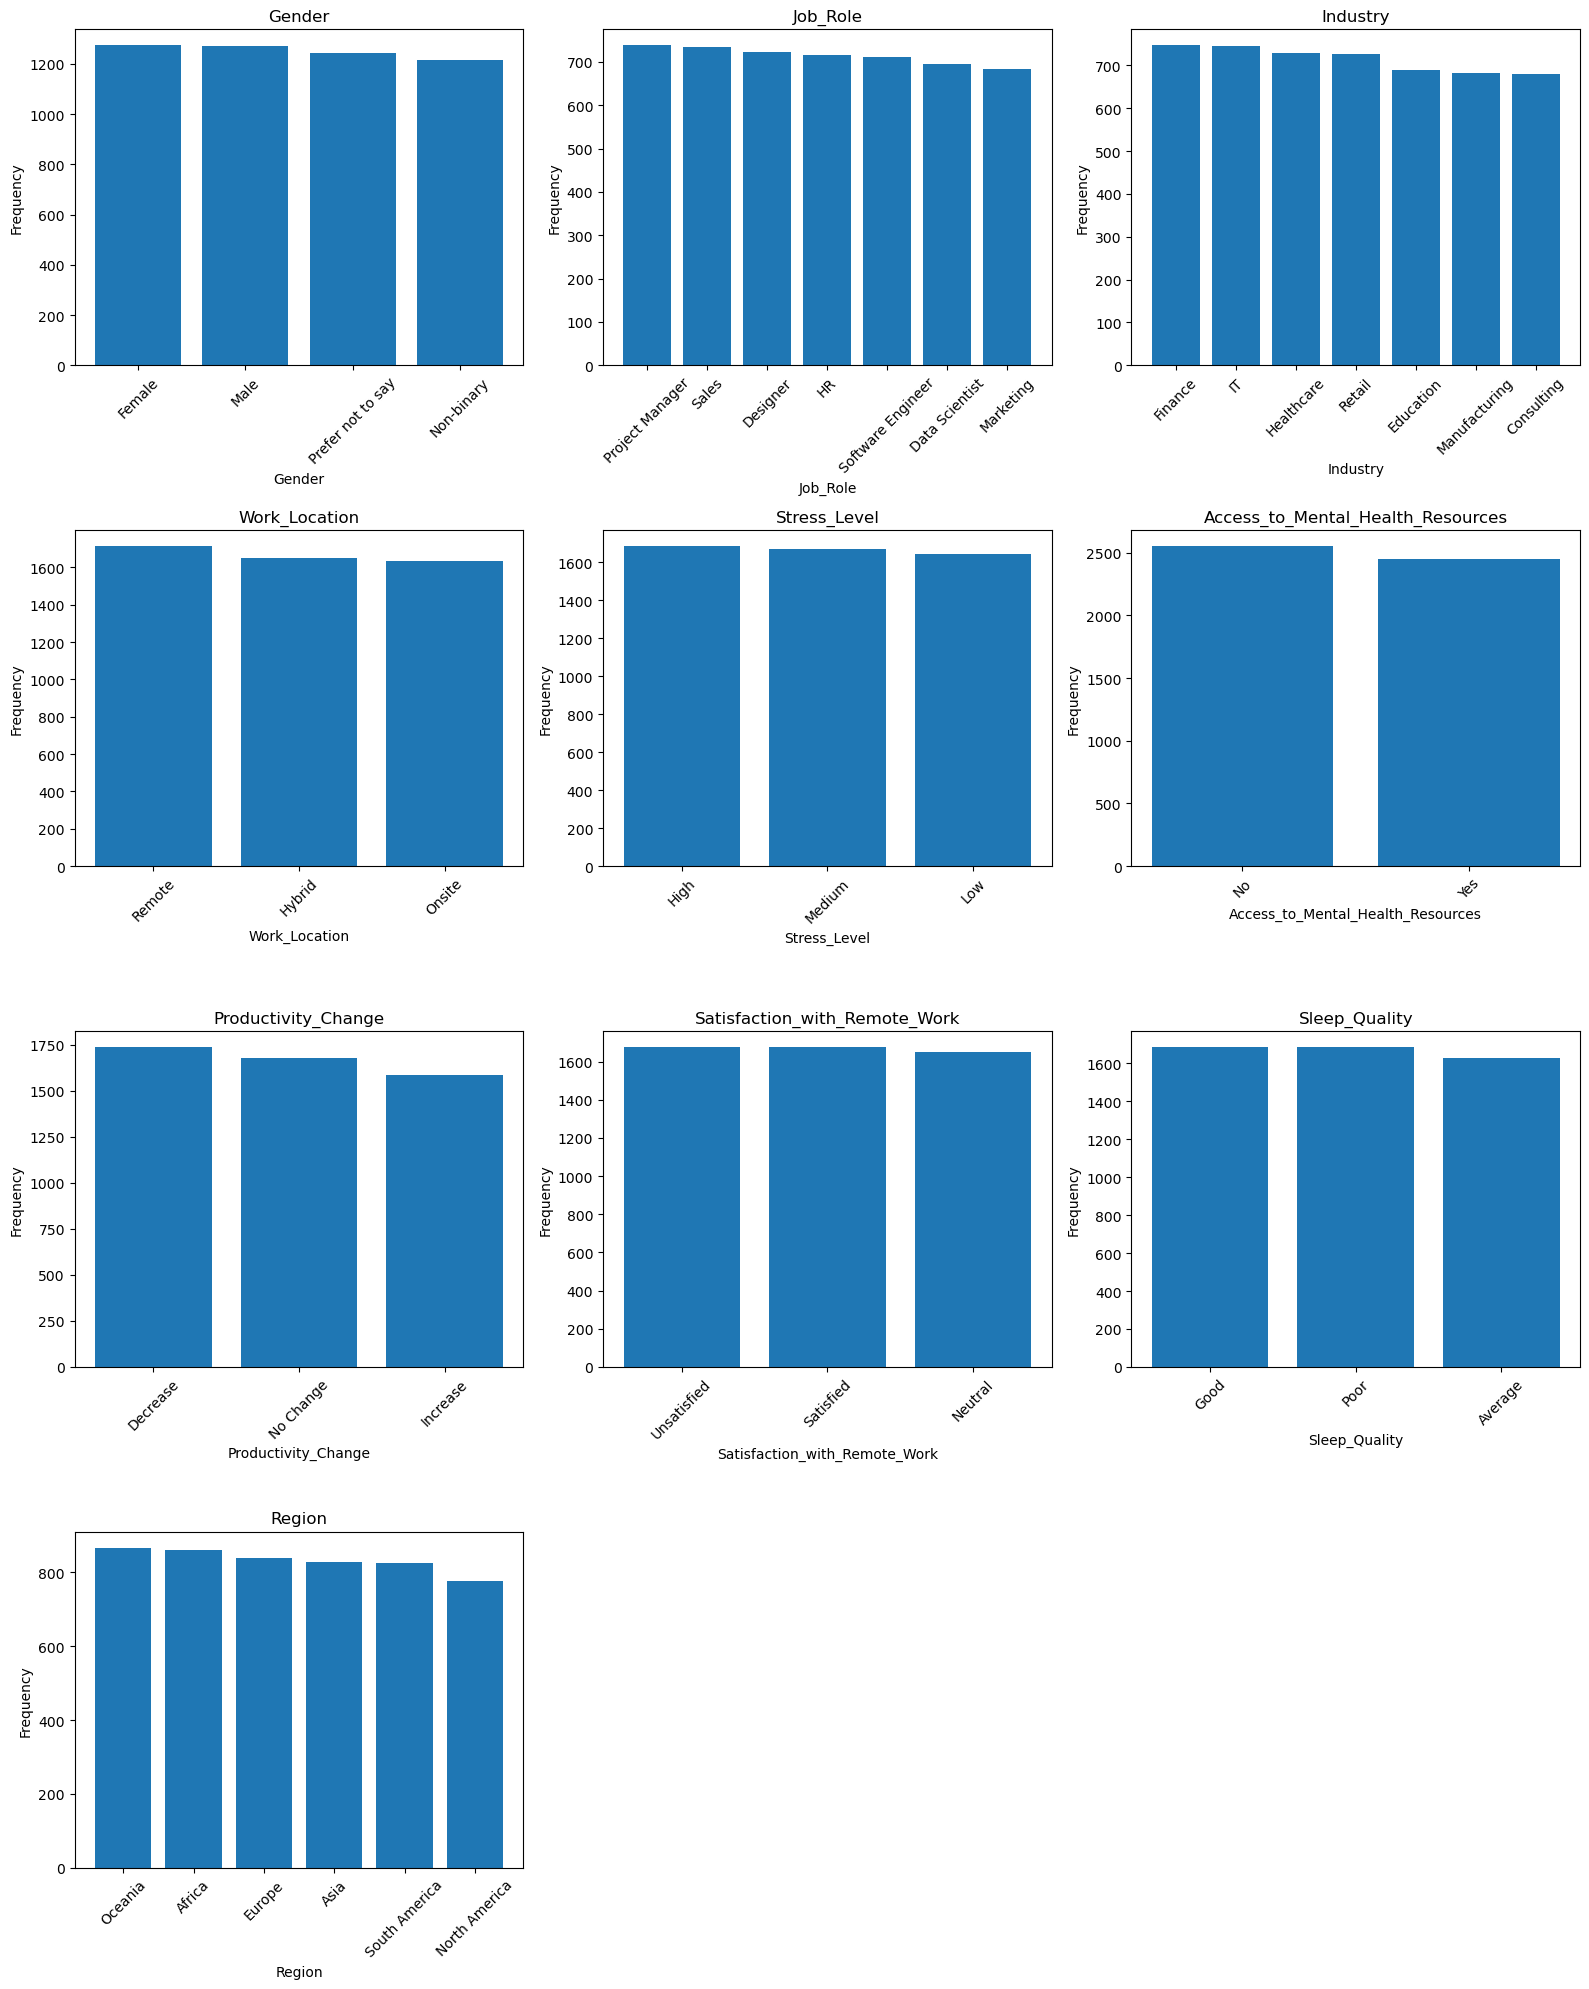

In [8]:
non_numerical_columns = data.select_dtypes(exclude=['number']).columns.tolist()

num_columns = 3  
num_rows = (len(non_numerical_columns) + num_columns - 1) // num_columns 

plt.figure(figsize=(16, 5 * num_rows))  

for i, column in enumerate(non_numerical_columns):
    plt.subplot(num_rows, num_columns, i + 1) 
    
    counts = data[column].value_counts()
    
    plt.bar(counts.index, counts.values)
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
    plt.xticks(rotation=45)

plt.tight_layout() 
plt.show()

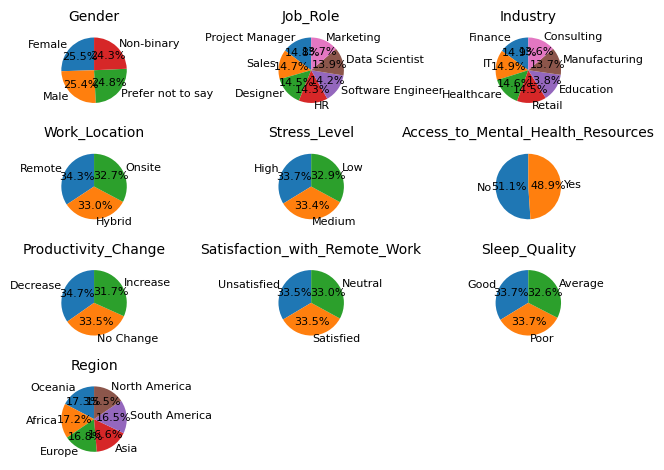

In [9]:
for i, column in enumerate(non_numerical_columns):
    plt.subplot(num_rows, num_columns, i + 1)  
    
    # Count occurrences of each unique value
    counts = data[column].value_counts()
    
    # Create pie chart
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, 
            textprops={'fontsize': 8})  # Adjust font size as needed
    plt.title(column, fontsize=10)
    

plt.tight_layout() 
plt.show()

In [10]:
# convert ordinal columns into numerical columns
def convert_ordinal_columns(df, mapping_dict):
    for column, mapping in mapping_dict.items():
        if column in df.columns:
            mapping = {k.lower(): v for k, v in mapping.items()}
            df[column] = df[column].apply(lambda x: mapping.get(str(x).lower(), "Undefined"))  
    return df


mapping_dict = {
    'Access_to_Mental_Health_Resources': {'no': 0, 'yes': 1},
    'Satisfaction_with_Remote_Work': {'unsatisfied': 0, 'neutral': 1, 'satisfied': 2},
    'Sleep_Quality': {'poor': 0, 'average': 1, 'good': 2},
    'Stress_Level': {'low': 0, 'medium': 1, 'high': 2},
    'Productivity_Change': {'Decrease': 0, 'No Change': 1, 'Increase': 2},
}

converted_df = convert_ordinal_columns(data, mapping_dict)

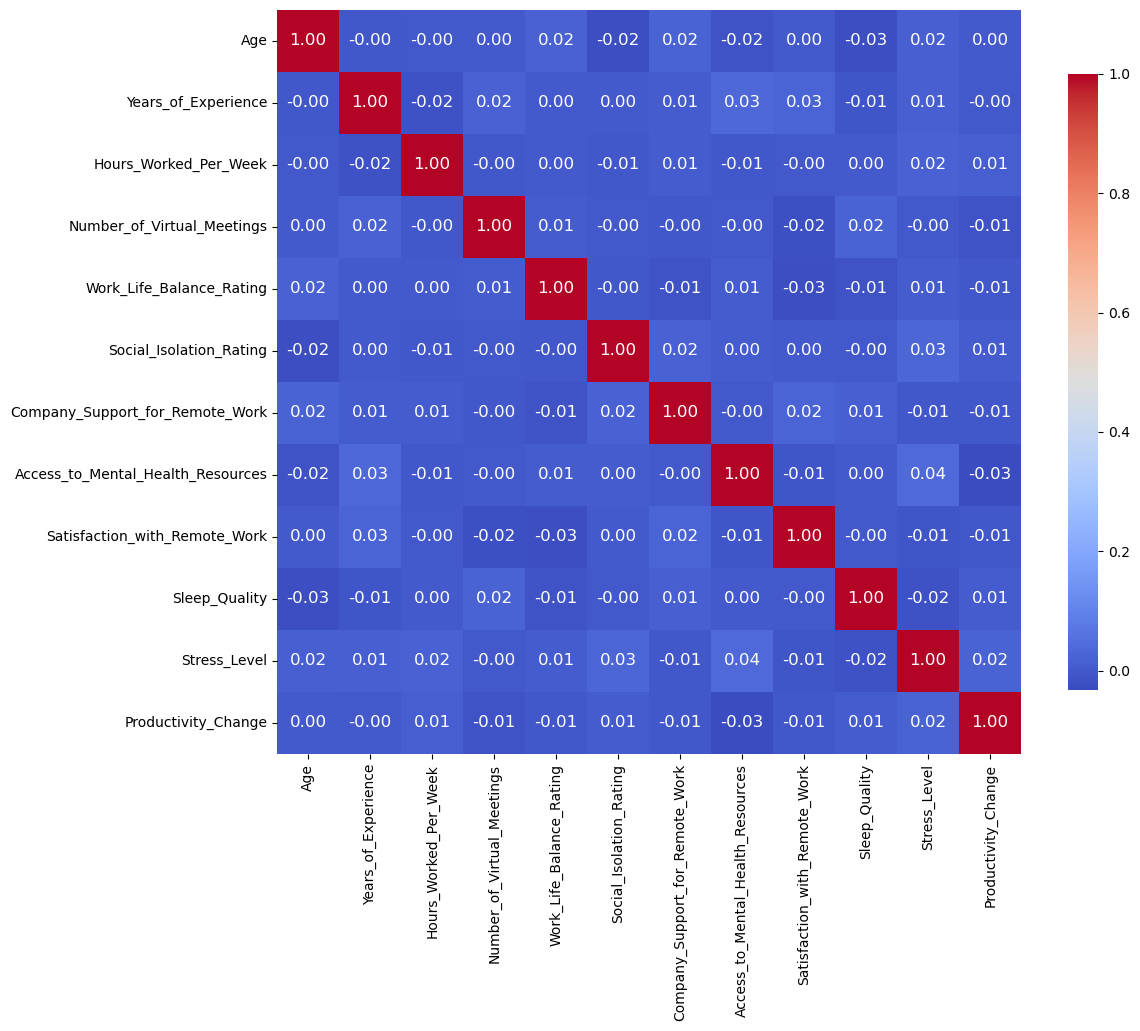

In [11]:
new_numerical_columns = numerical_columns + ["Access_to_Mental_Health_Resources","Satisfaction_with_Remote_Work","Sleep_Quality","Stress_Level","Productivity_Change"]
correlation_matrix = converted_df[new_numerical_columns].corr()

# Plot the heatmap with adjusted figure size and annotation font size
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, cbar_kws={"shrink": .8}, annot_kws={"size": 12})
plt.show()

## PC algorithm

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Green: undirected; Blue: directed; Red: bi-directed



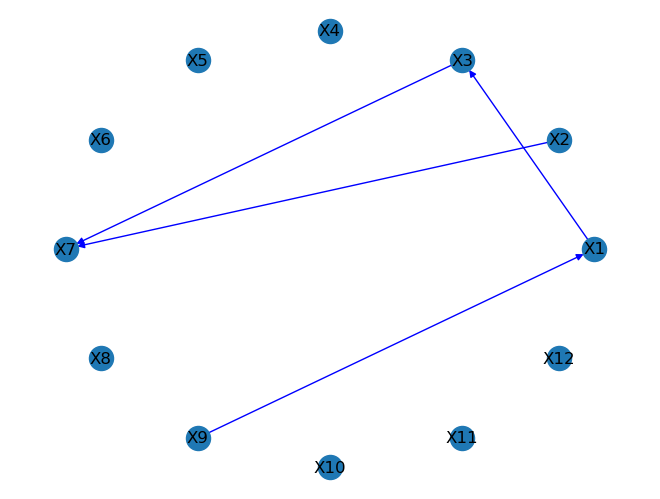

In [12]:
from causallearn.search.ConstraintBased.PC import pc

# Define default or example values for parameters
alpha = 0.05  # Common threshold for independence testing
indep_test = "gsq"  # Typically 'fisherz' for continuous data
stable = True  # Whether to use a stable version of the algorithm
uc_rule = 0  # Unshielded collider discovery rule (0, 1, or 2; try default 0 first)
uc_priority = False  # Unshielded collider priority; default False
mvpc = False  # Missing values in PC algorithm, default False
correction_name = None  # Name of correction for independence tests; default None
background_knowledge = None  # Optional prior knowledge to guide the algorithm
verbose = False  # Whether to print additional info during execution
show_progress = True  # Show progress in long runs

# default parameters
cg = pc(converted_df[new_numerical_columns].values)

# or customized parameters
cg = pc(converted_df[new_numerical_columns].values, alpha, indep_test, stable, uc_rule, uc_priority, mvpc, correction_name, background_knowledge, verbose, show_progress)

# visualization using pydot
#cg.draw_pydot_graph()

# or save the graph
#from causallearn.utils.GraphUtils import GraphUtils

#pyd = GraphUtils.to_pydot(cg.G)
#pyd.write_png('simple_test.png')

# visualization using networkx
cg.to_nx_graph()
cg.draw_nx_graph(skel=False)

In [13]:
# # convert categories columns into numerical columns
# converted_df = converted_df.replace(' ', '_', regex=True)
# converted_df = pd.get_dummies(converted_df, columns=['Gender', 'Work_Location', 'Job_Role', 'Industry', 'Region'])
# converted_df = converted_df.astype(int)

# correlation_matrix = converted_df.corr()
# mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# plt.figure(figsize=(14, 12))
# sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix')
# plt.show()

In [14]:
# from causallearn.search.ConstraintBased.PC import pc

# # Define default or example values for parameters
# alpha = 0.05  # Common threshold for independence testing
# indep_test = "gsq"  # Typically 'fisherz' for continuous data
# stable = True  # Whether to use a stable version of the algorithm
# uc_rule = 0  # Unshielded collider discovery rule (0, 1, or 2; try default 0 first)
# uc_priority = False  # Unshielded collider priority; default False
# mvpc = False  # Missing values in PC algorithm, default False
# correction_name = None  # Name of correction for independence tests; default None
# background_knowledge = None  # Optional prior knowledge to guide the algorithm
# verbose = False  # Whether to print additional info during execution
# show_progress = True  # Show progress in long runs

# # default parameters
# cg = pc(converted_df.values)

# # or customized parameters
# cg = pc(converted_df.values, alpha, indep_test, stable, uc_rule, uc_priority, mvpc, correction_name, background_knowledge, verbose, show_progress)

# # visualization using pydot
# #cg.draw_pydot_graph()

# # or save the graph
# #from causallearn.utils.GraphUtils import GraphUtils

# #pyd = GraphUtils.to_pydot(cg.G)
# #pyd.write_png('simple_test.png')

# # visualization using networkx
# cg.to_nx_graph()
# plt.figure(figsize=(12, 8))
# cg.draw_nx_graph(skel=False)
# plt.show()

## LiNGAM (Linear Non-Gaussian Acyclic Model)

In [15]:
from lingam import DirectLiNGAM

# Assuming 'converted_df' is your DataFrame with numerical data
model = DirectLiNGAM()
model.fit(converted_df[new_numerical_columns])

# Get the causal order and adjacency matrix
causal_order = model.causal_order_
adjacency_matrix = model.adjacency_matrix_

print("Causal Order:", causal_order)
print("Adjacency Matrix:", adjacency_matrix)

Causal Order: [7, 9, 10, 11, 8, 4, 5, 6, 2, 1, 3, 0]
Adjacency Matrix: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Generalized Additive Model (GAM)

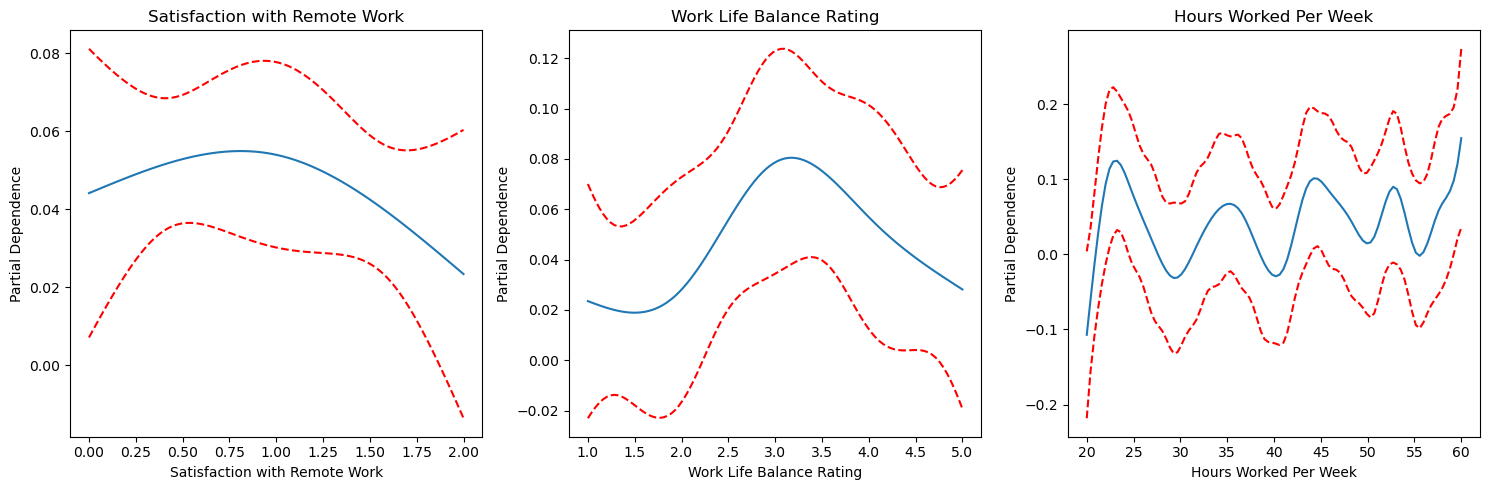

In [16]:
from pygam import LinearGAM, s

# Predict 'Stress_Level' based on 'Satisfaction_with_Remote_Work' and other relevant predictors
X = converted_df[['Satisfaction_with_Remote_Work', 'Work_Life_Balance_Rating', 'Hours_Worked_Per_Week']].values
y = converted_df['Stress_Level'].values

gam = LinearGAM(s(0) + s(1) + s(2))  # Using smooth terms for each predictor
gam.fit(X, y)

# Plot the partial dependence for each predictor
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
titles = ['Satisfaction with Remote Work', 'Work Life Balance Rating', 'Hours Worked Per Week']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], color='r', ls='--')
    ax.set_title(titles[i])
    ax.set_xlabel(titles[i])
    ax.set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

## Bayesian Networks with pgmpy

  0%|          | 0/1000000 [00:00<?, ?it/s]

Edges in Bayesian Network: []


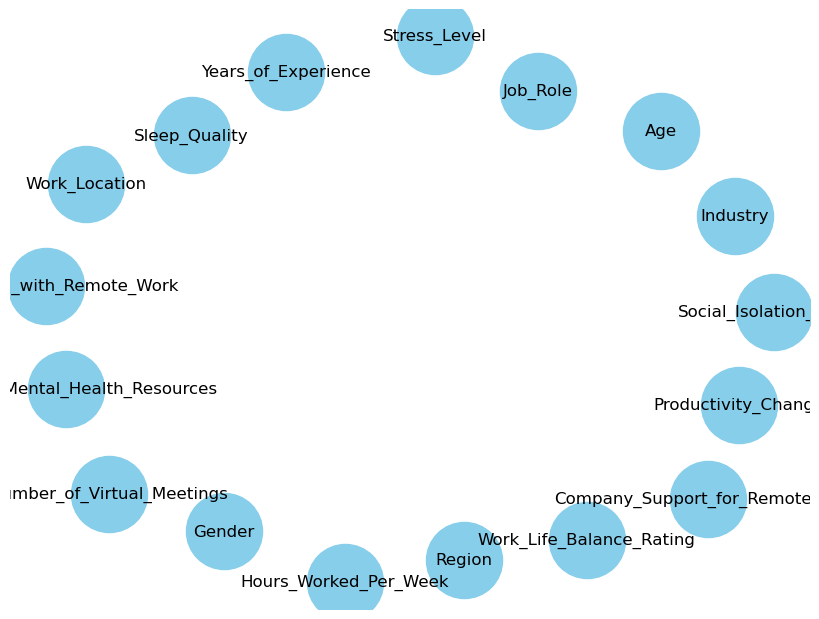

In [17]:
from pgmpy.estimators import HillClimbSearch, K2Score
from pgmpy.models import BayesianNetwork
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Assuming all variables in 'converted_df' are relevant
hc = HillClimbSearch(converted_df)
model = hc.estimate(scoring_method=K2Score(converted_df))

# Print the edges in the network
print("Edges in Bayesian Network:", model.edges())

# Visualize the Bayesian Network
nx.draw(model, with_labels=True, node_size=3000, node_color='skyblue')
plt.show()